In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For comparison
import csr2d.core2

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# 3D CSR Potentials

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_z = 10e-6
sigma_x = 10e-6 
rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2


# alpha

For convenience we will use the notatation

$\xi \rightarrow z$

$\chi \rightarrow x$

$\zeta \rightarrow y$

Then 

$z = \alpha - \frac{\beta}{2}\sqrt{x^2+y^2+4(1+x)\sin^2\alpha}$

In [5]:
from csr3d.core import alpha_exact, alpha, old_alpha, alpha_where_z_equals_zero, psi_s

In [6]:
xmax = 40e-6 #1/gamma**2
xmin = -xmax
xptp = xmax-xmin

ymax = 40e-6  #1/gamma**2
ymin = -ymax
yptp = ymax-ymin

zmax = 40e-6  #1/gamma**2
zmin = -zmax
zptp = zmax-zmin

fac = 2
nx = int(32*fac)
ny = int(16*fac)
nz = int(64*fac)

dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

xmax, ymax, zmax

(4e-05, 4e-05, 4e-05)

# alpha

In [7]:
%%timeit
old_alpha(X, Y, Z, gamma)

48.5 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
alpha(X, Y, Z, gamma)

24.2 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# This will be slow
A0 = alpha_exact(X, Y, Z, gamma)

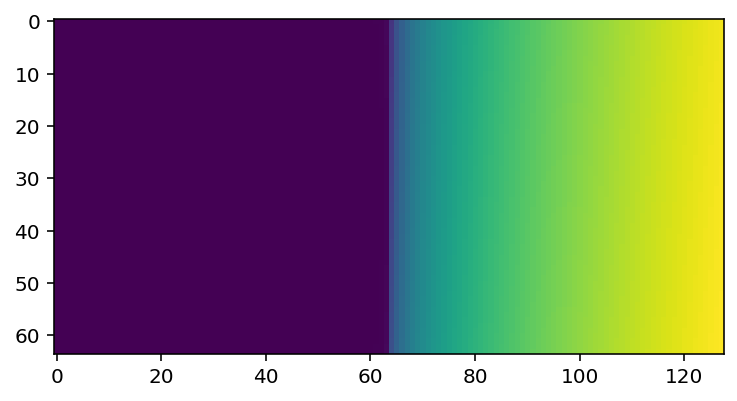

In [10]:
plt.imshow(A0[:,1,:])

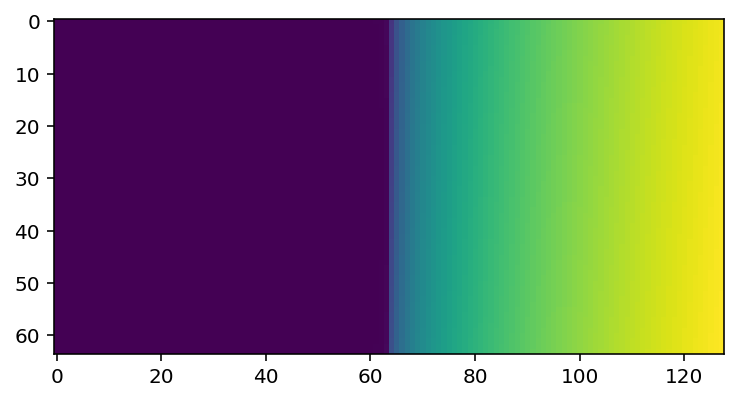

In [11]:
A1 = alpha(X, Y, Z, gamma)
plt.imshow(A1[:,1,:])

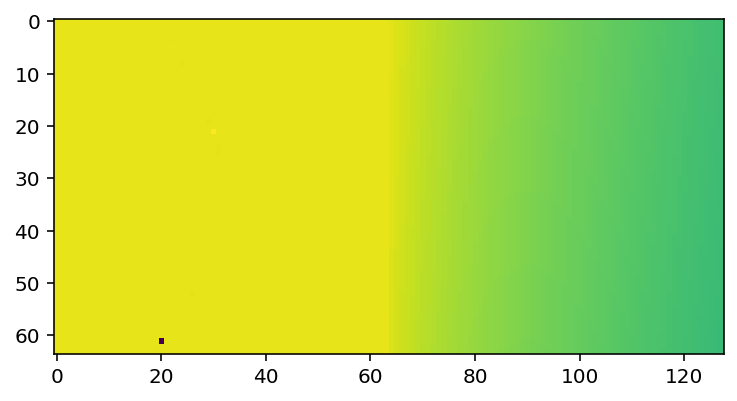

In [12]:
err = (A1-A0)/A0
np.abs(err).max()
plt.imshow(err[:,0,:])

Text(0, 0.5, 'relative error (10^-6)')

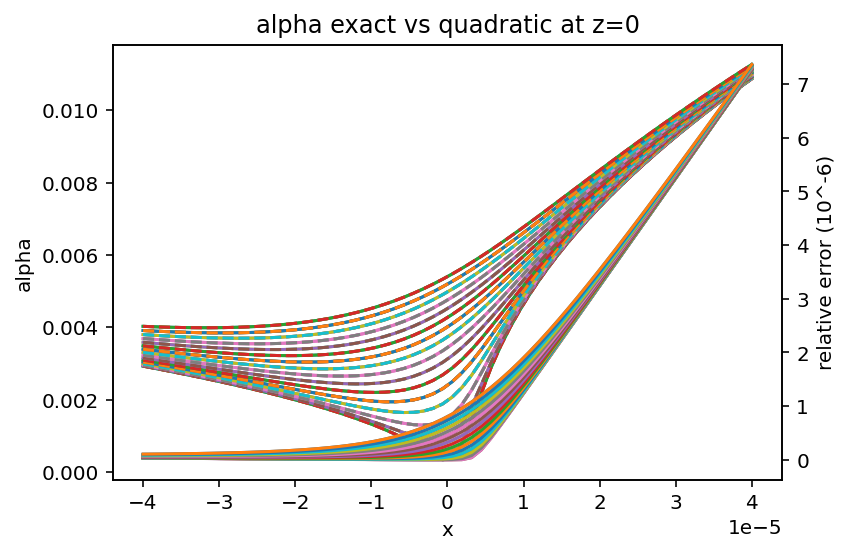

In [13]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
for y0 in yvec:
    a0 =  alpha_exact(xvec, y0, 0, gamma)
    a1 = alpha_where_z_equals_zero(xvec, y0, gamma)
    err = (a1-a0)/a0
    ax.plot(xvec, a0)
    ax.plot(xvec, a1, linestyle='--')
    ax2.plot(xvec, abs(err)*1e6)

ax.set_title('alpha exact vs quadratic at z=0')
ax.set_xlabel('x')
ax.set_ylabel('alpha')
ax2.set_ylabel('relative error (10^-6)')

# psi_s

In [14]:
from csr3d.core import psi_s

In [15]:
%%timeit
# This is parallel
psi_s(X, Y, Z, gamma)

8.32 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
psi_s(0,0,0, gamma)

0.0

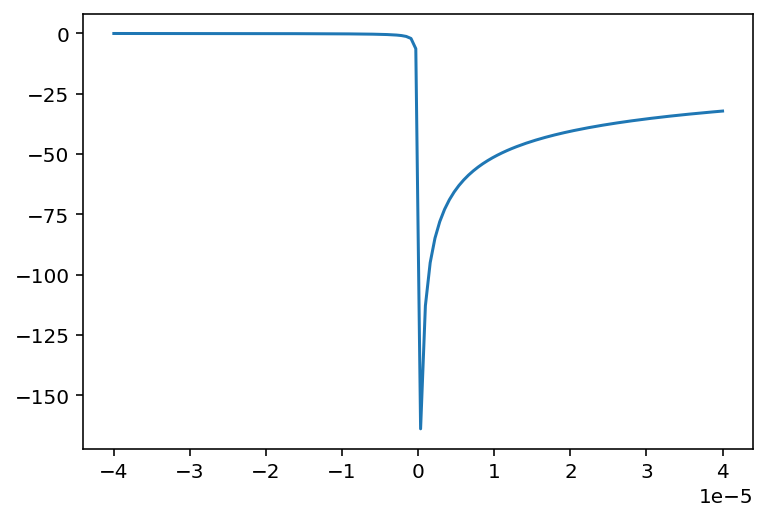

In [17]:
plt.plot(zvec, psi_s(0, 0, zvec, gamma))

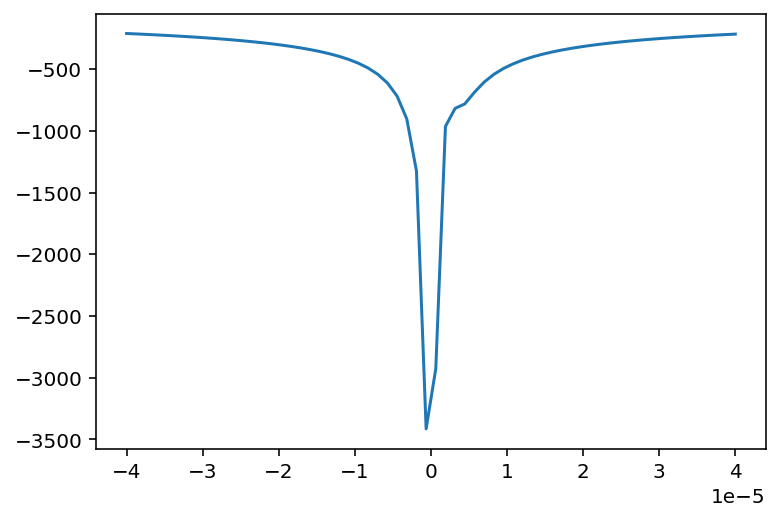

In [18]:
plt.plot(xvec, psi_s(xvec, 0, 0, gamma))

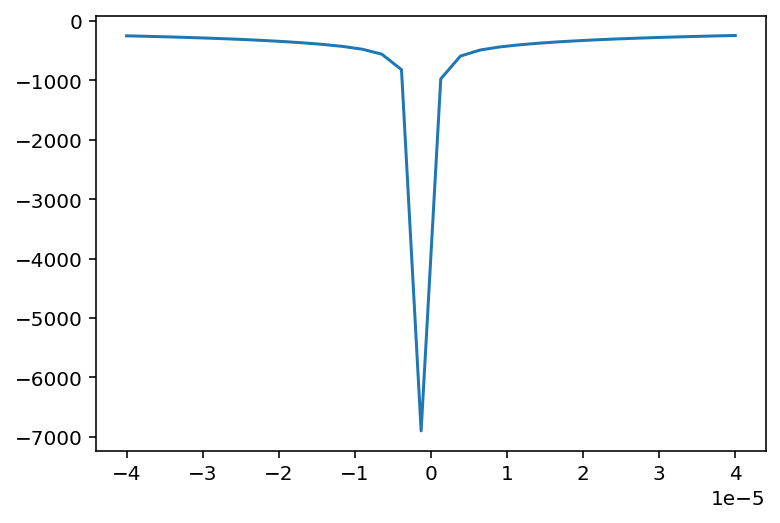

In [19]:
plt.plot(yvec, psi_s(0, yvec+1e-6, 0, gamma))

In [20]:
# Compare with CSR2D
def csr2d_psi_s(*a, **k):
    return csr2d.core2.psi_s(*a, **k) + csr2d.core2.psi_s_SC(*a, **k)/gamma**2

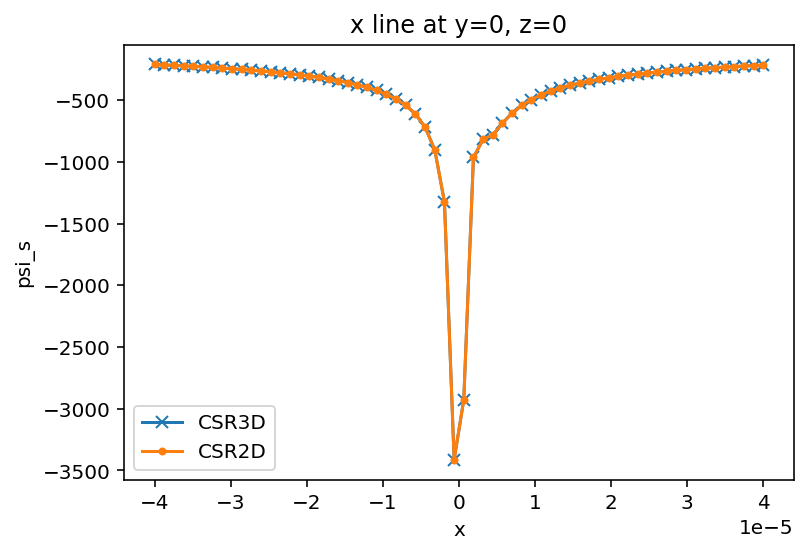

In [21]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_s(xvec,0,0,gamma), label='CSR3D', marker='x')
#ax.plot(xvec, csr2d.core2.psi_s(0, xvec, beta), marker='.', label='CSR2D')
ax.plot(xvec,csr2d_psi_s(0, xvec, beta), marker='.', label='CSR2D')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('x')
ax.legend()

Text(0.5, 0, 'y')

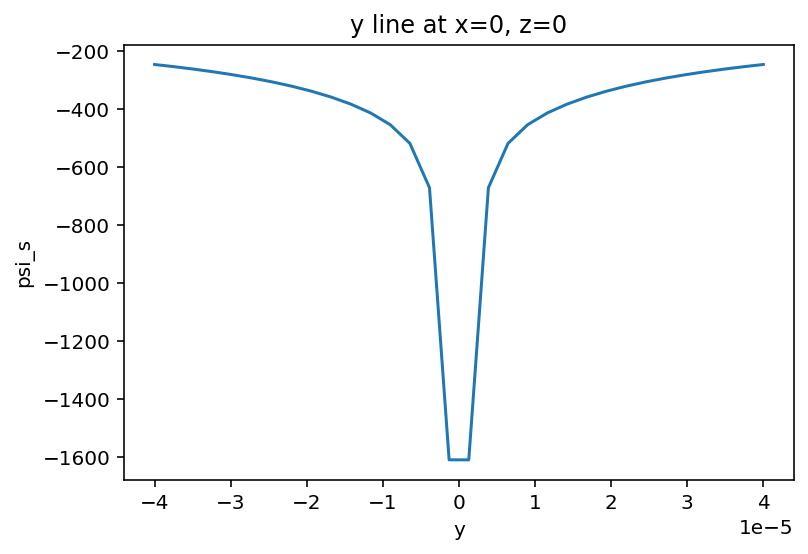

In [22]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_s(0,yvec,0,gamma))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('y')
#ax.legend()

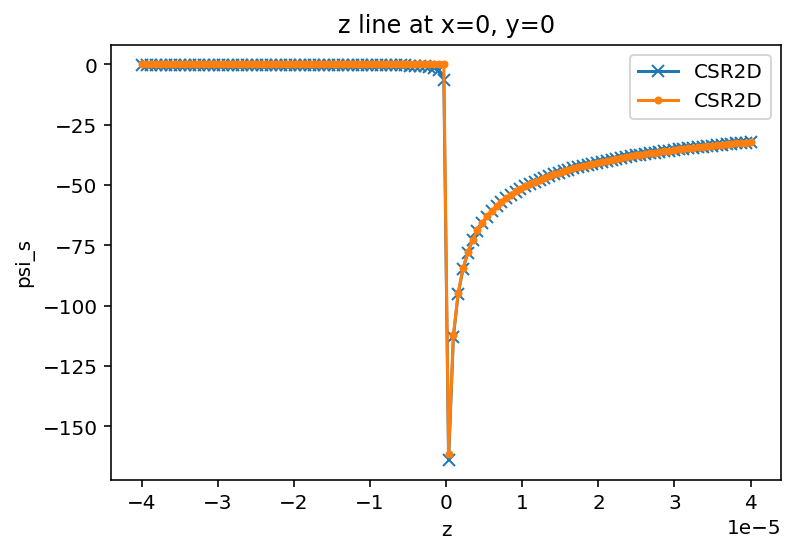

In [23]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_s(0,0,zvec,gamma), marker='x', label='CSR2D')
ax.plot(zvec, csr2d.core2.psi_s(zvec, 0,beta), marker='.', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('z')
ax.legend()

# psi_s mesh

In [24]:
from csr3d.wake import green_mesh

In [25]:
%%time
G = green_mesh((nx, ny, nz), (dx, dy, dz), rho=rho, gamma=gamma, component='s')

CPU times: user 458 ms, sys: 35.1 ms, total: 493 ms
Wall time: 107 ms


In [26]:
%%time
Gs = green_mesh((nx, ny, nz), (dx, dy, dz/100), rho=rho, gamma=gamma, component='s')

CPU times: user 566 ms, sys: 40.3 ms, total: 607 ms
Wall time: 111 ms


Text(0.5, 1.0, '$\\psi_s$')

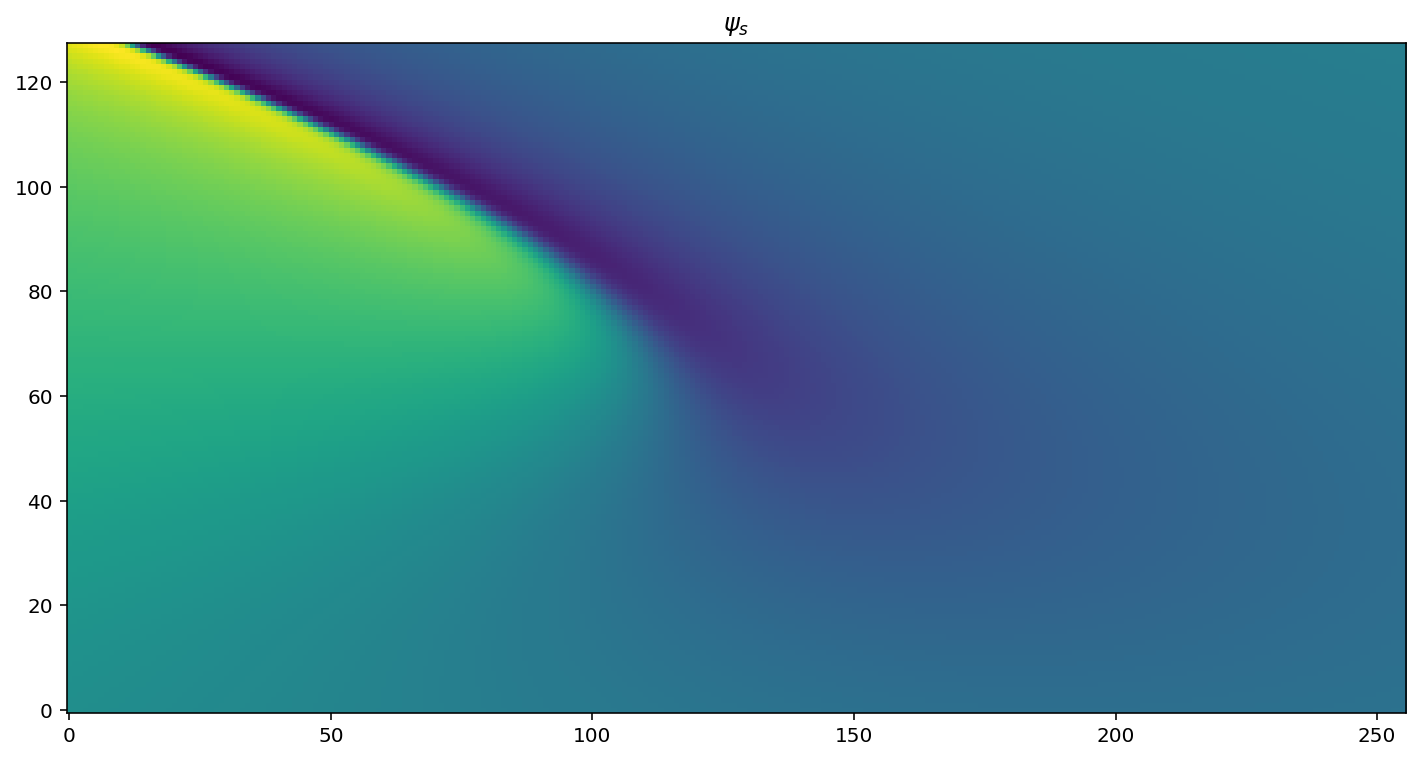

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gs[:,ny//2,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_s$')

# psi_x

In [28]:
from csr3d.wake import green_mesh
from csr3d.core import psi_x, psi_x0

# Compare with CSR2D at y=0
import csr2d.core2 

In [29]:
%%timeit
psi_x(X, Y, Z, gamma)

112 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
# This is parallelized
psi_x0(X, Y, Z, gamma, dx, dy, dz)

21.2 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
# Compare with CSR2D
def csr2d_psi_x(*a, **k):
    return csr2d.core2.psi_x(*a, **k) + csr2d.core2.psi_x_SC(*a, **k)/gamma**2

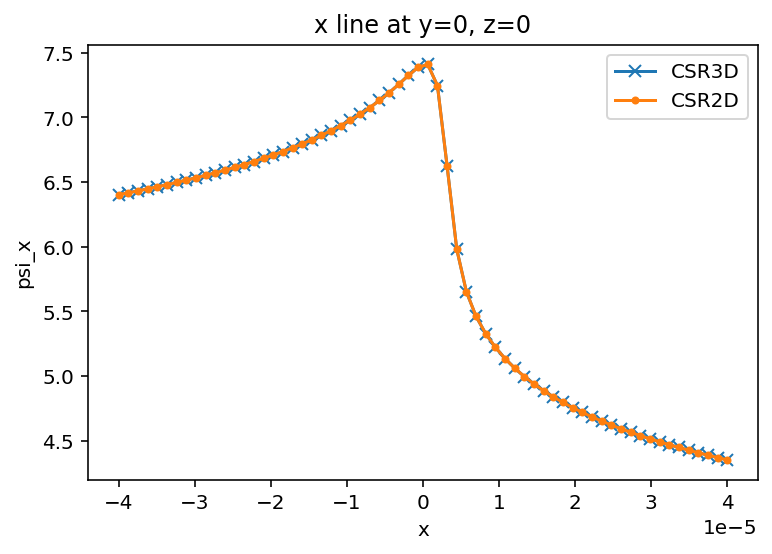

In [32]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_x(xvec,0,0,gamma), label='CSR3D', marker='x')
ax.plot(xvec, csr2d_psi_x(0, xvec,beta), marker='.', label='CSR2D')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('x')
ax.legend()

Text(0.5, 0, 'y')

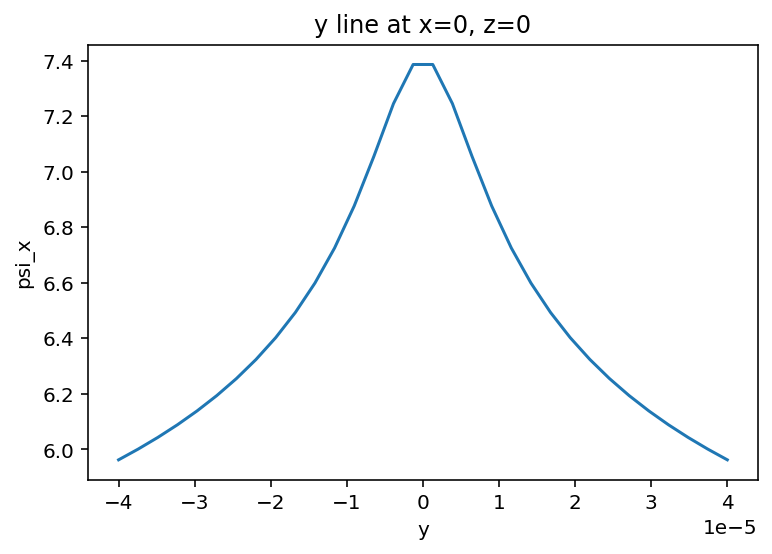

In [33]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_x(0,yvec,0,gamma))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('y')
#ax.legend()

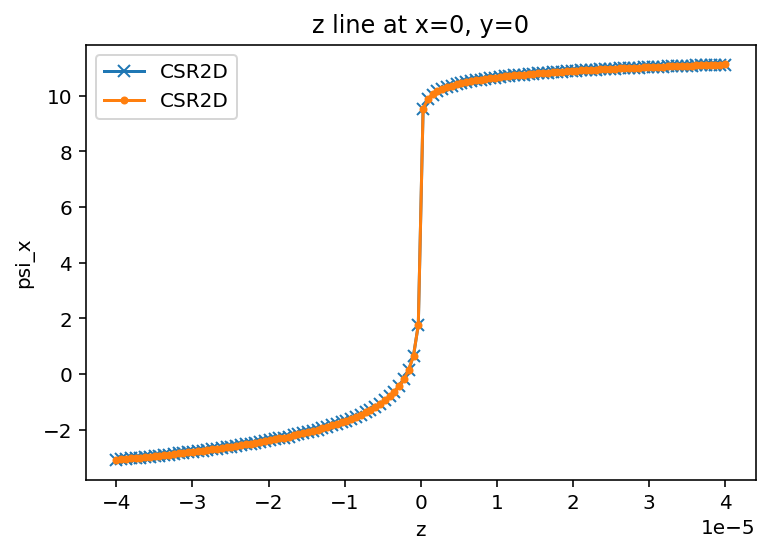

In [34]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_x0(0,0,zvec,gamma,1e-6, 1e-6, 1e-6), marker='x', label='CSR2D')
ax.plot(zvec, csr2d.core2.psi_x0(zvec, 0,beta, 1e-6), marker='.', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('z')
ax.legend()

In [35]:
%%time
Gx = green_mesh((nx, ny, nz), (dx, dy, dz), rho=rho, gamma=gamma, component='x')
#X2, Y2, Z2 = tuple(meshes)

CPU times: user 1.42 s, sys: 43.7 ms, total: 1.46 s
Wall time: 280 ms


Text(0, 0.5, 'x index')

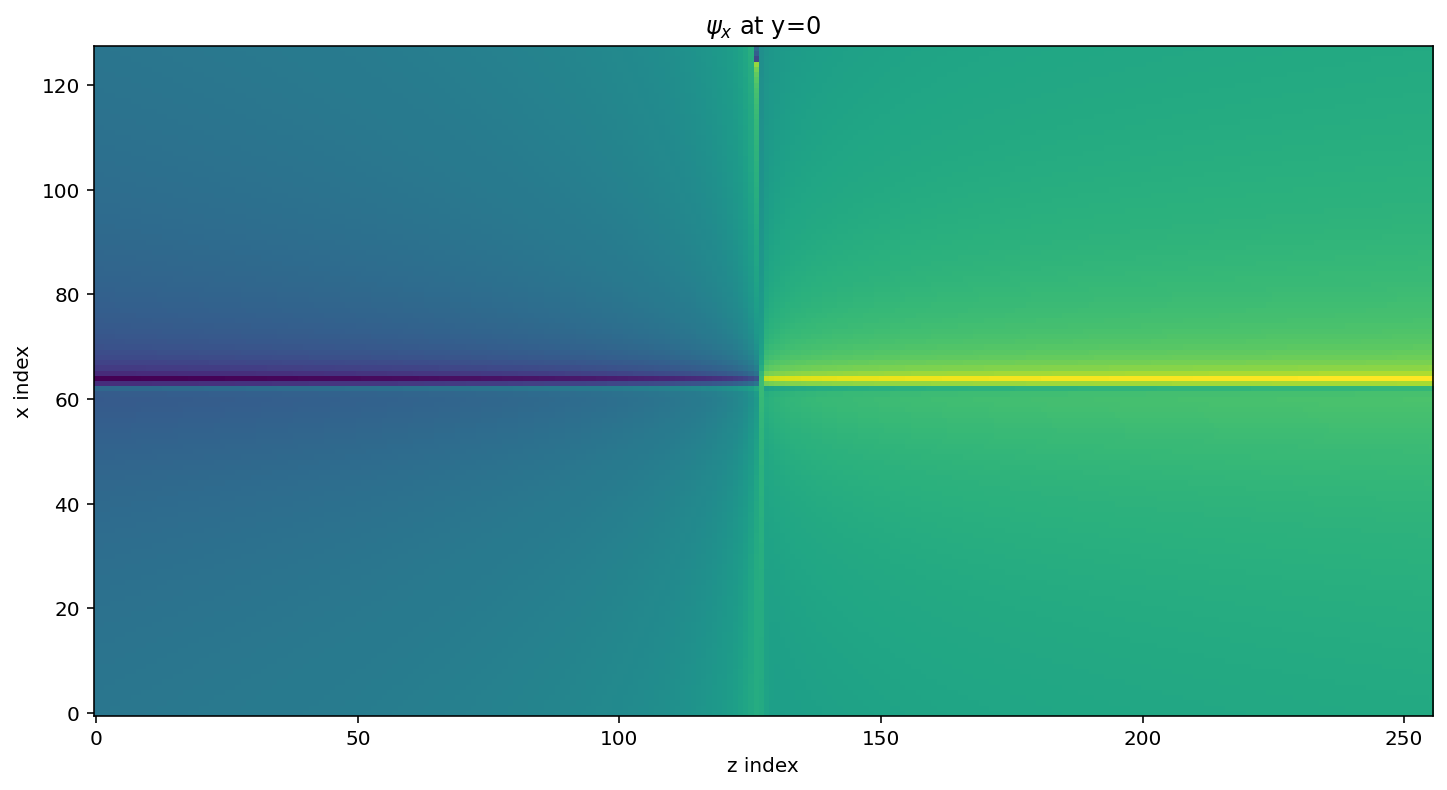

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gx[:,ny-1,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at y=0')
ax.set_xlabel('z index')
ax.set_ylabel('x index')

Text(0, 0.5, 'y index')

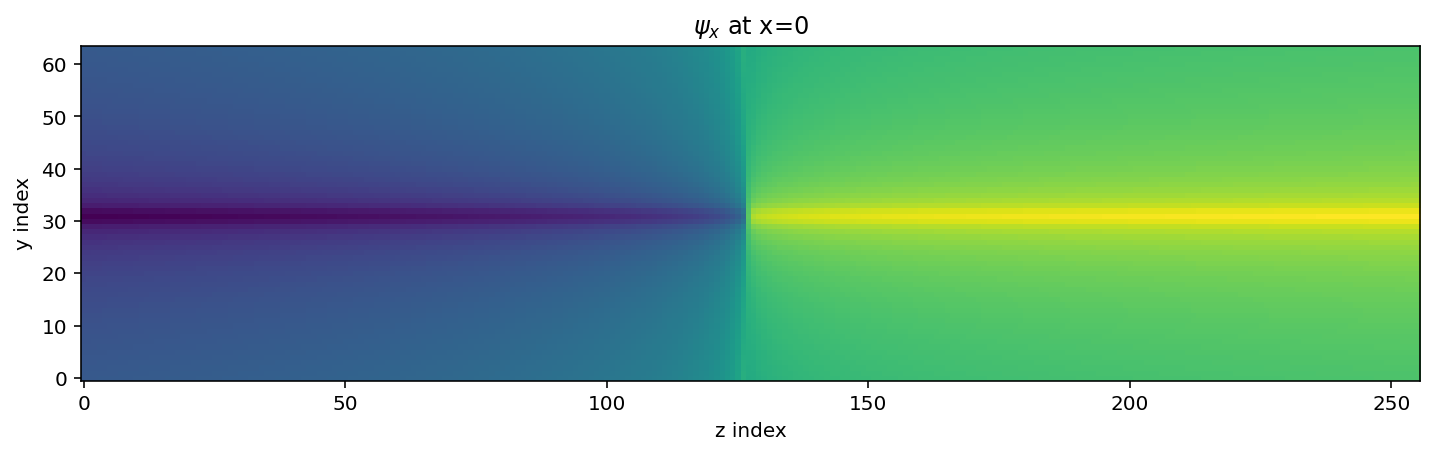

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gx[nx-1,:,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at x=0')
ax.set_xlabel('z index')
ax.set_ylabel('y index')

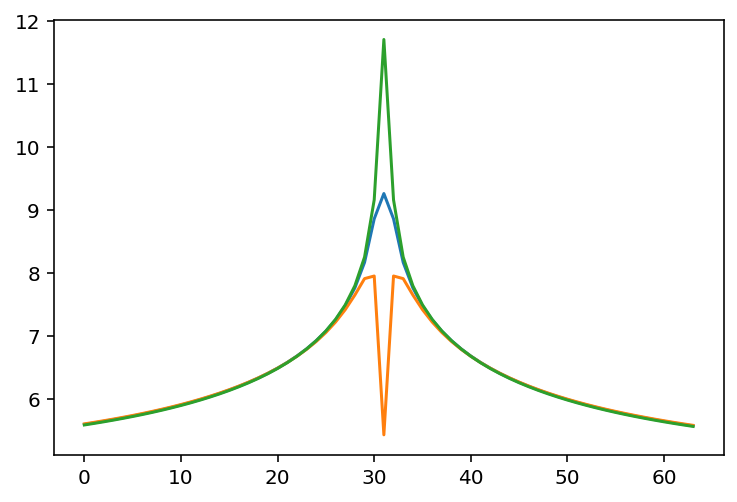

In [38]:
plt.plot(Gx[nx-1,:,nz])
plt.plot(Gx[nx-1-1,:,nz])

plt.plot(Gx[nx-1+1,:,nz])

Text(0, 0.5, 'y index')

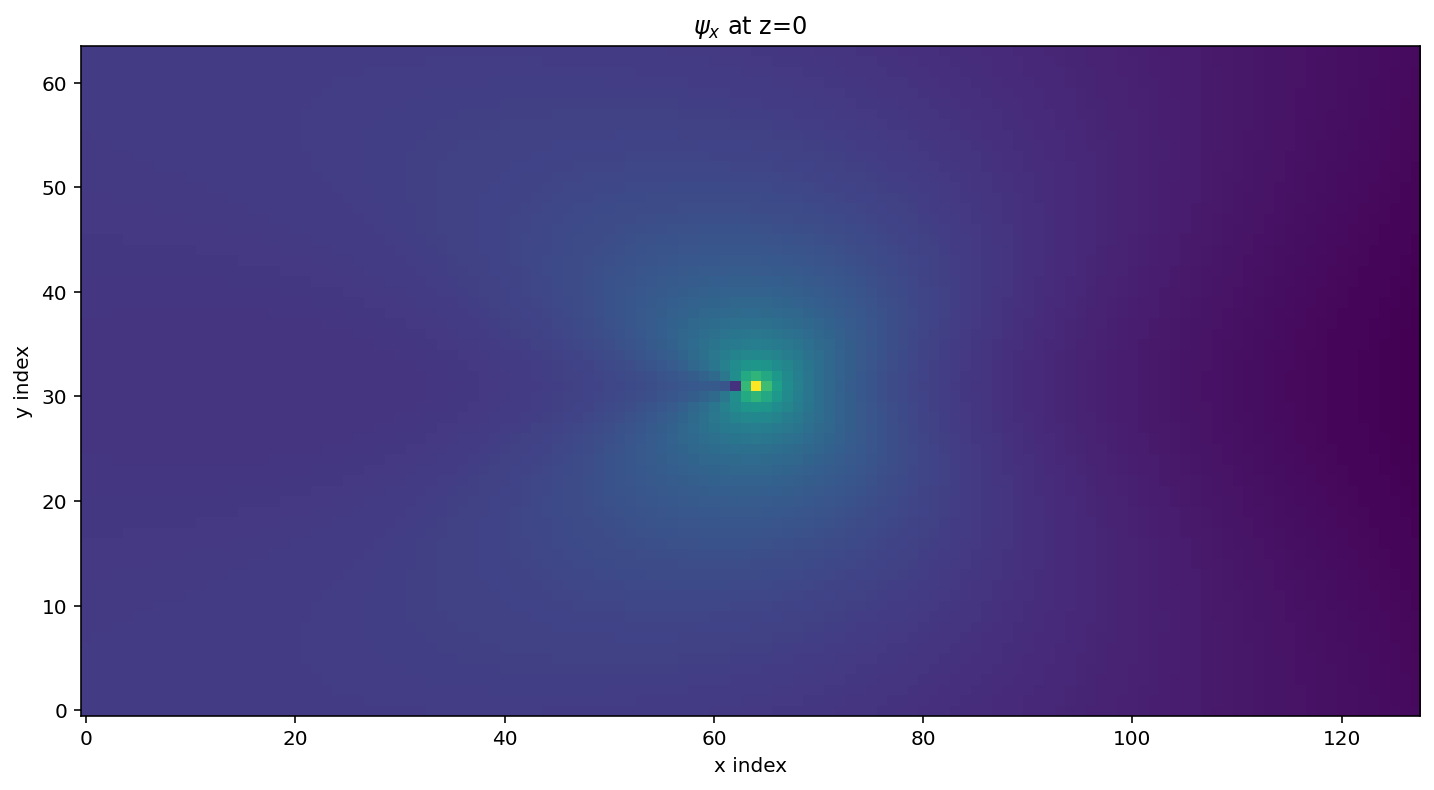

In [39]:
M = Gx[:,:,nz].T

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(M, origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at z=0')
ax.set_xlabel('x index')
ax.set_ylabel('y index')

# psi_y

In [40]:
from csr3d.core import psi_y, psi_y0

In [41]:
%%timeit
R2 = psi_y(X, Y, Z, gamma)

123 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%%timeit
R2 = psi_y0(X, Y, Z, gamma, dx, dy, dz)

20.5 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%%time
Gy = green_mesh((nx, ny, nz), (dx/10, dy/10, dz/100), rho=rho, gamma=gamma, component='y')
#X2, Y2, Z2 = tuple(meshes)

CPU times: user 1.44 s, sys: 42.3 ms, total: 1.48 s
Wall time: 194 ms


Text(0, 0.5, 'x index')

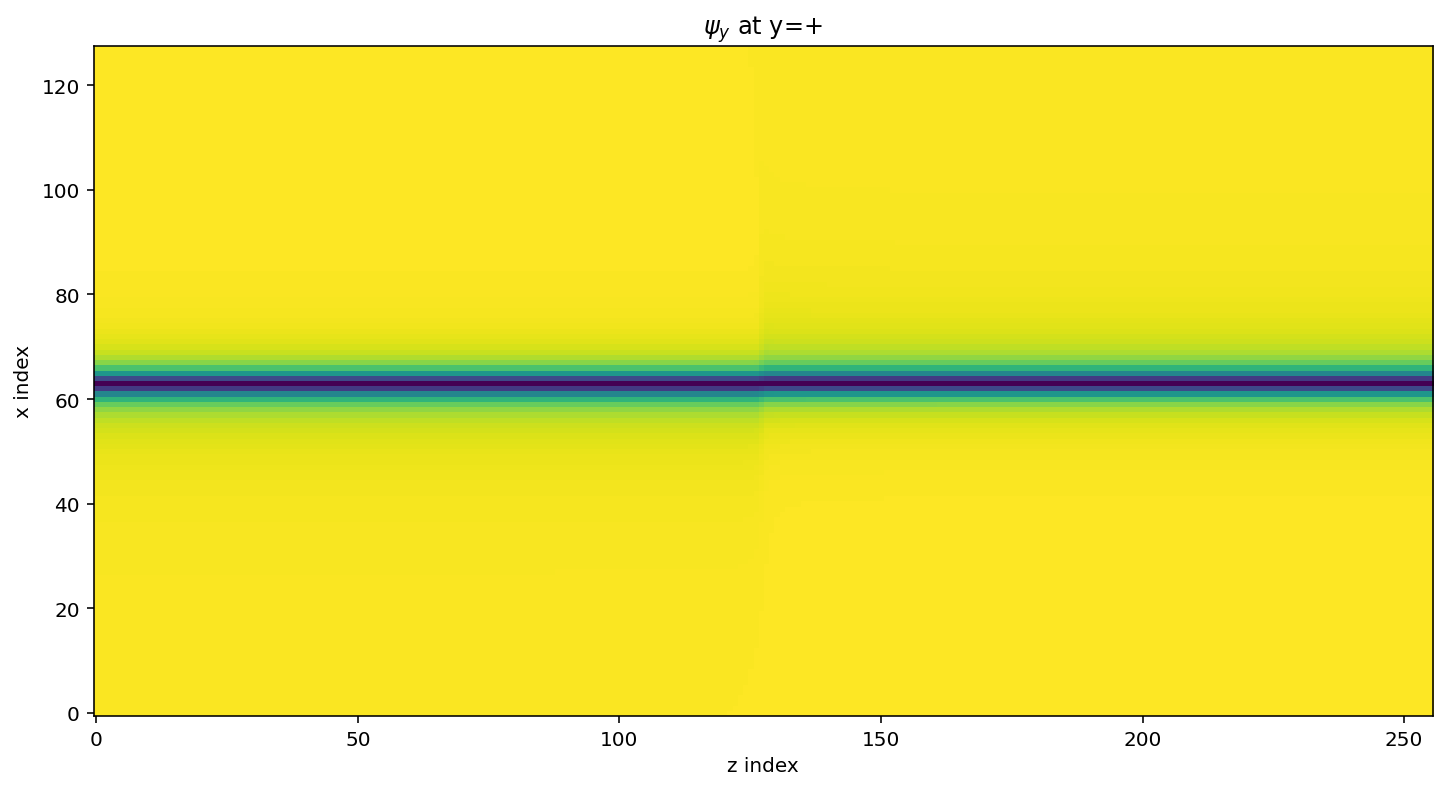

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gy[:,ny-1 +1,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at y=+')
ax.set_xlabel('z index')
ax.set_ylabel('x index')

Text(0, 0.5, 'y index')

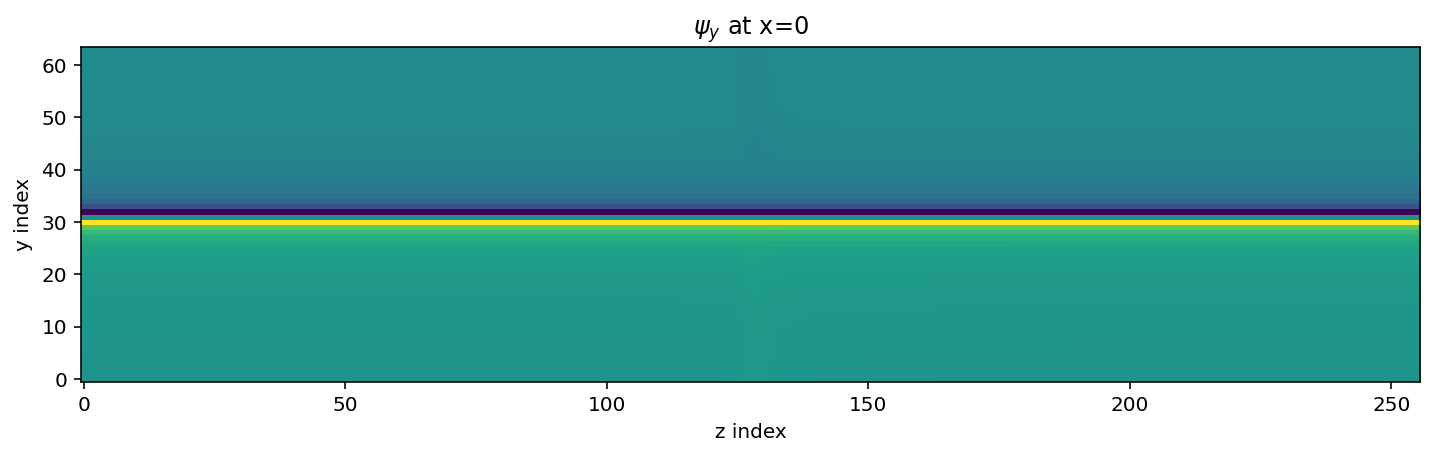

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gy[nx-1,:,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at x=0')
ax.set_xlabel('z index')
ax.set_ylabel('y index')

Text(0, 0.5, 'y index')

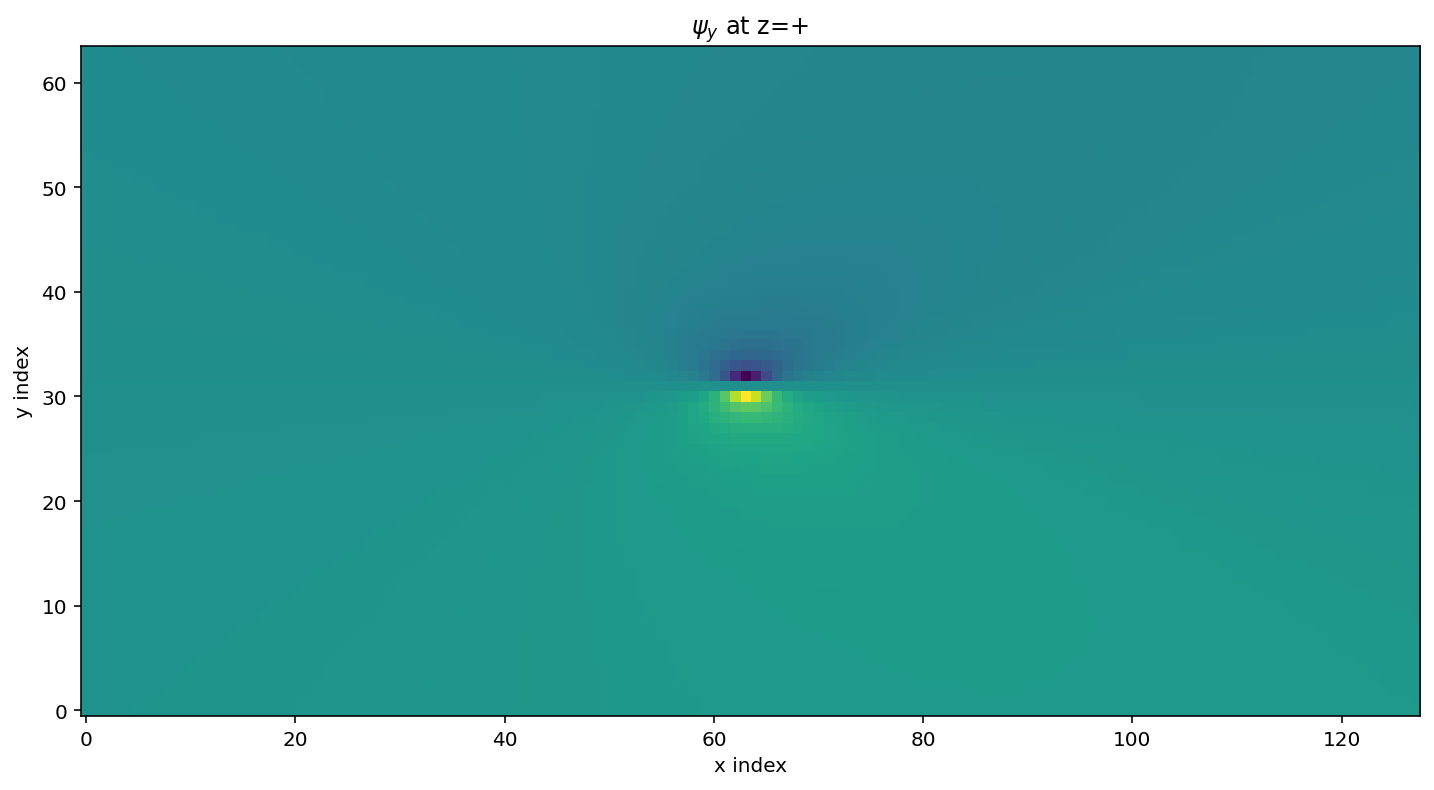

In [46]:
M = Gy[:,:,nz].T

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(M, origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at z=+')
ax.set_xlabel('x index')
ax.set_ylabel('y index')

Text(0.5, 0, 'x')

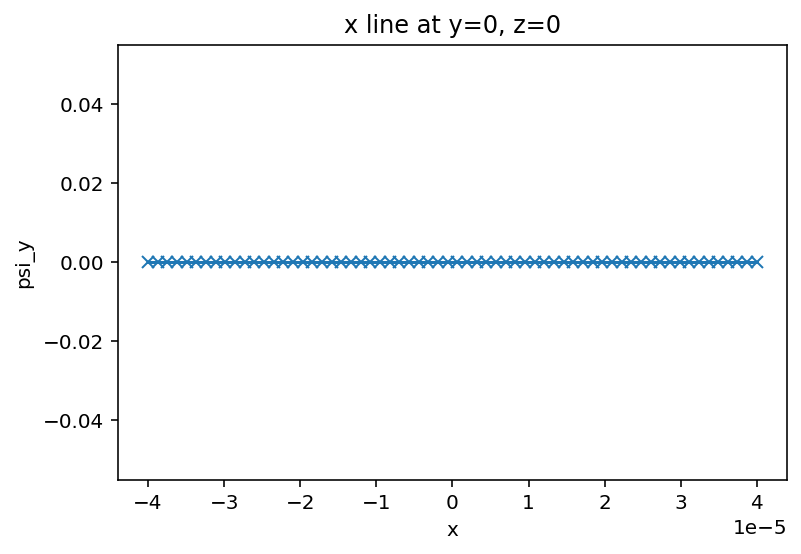

In [47]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_y(xvec,0,0,gamma), label='CSR3D', marker='x')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('x')

Text(0.5, 0, 'y')

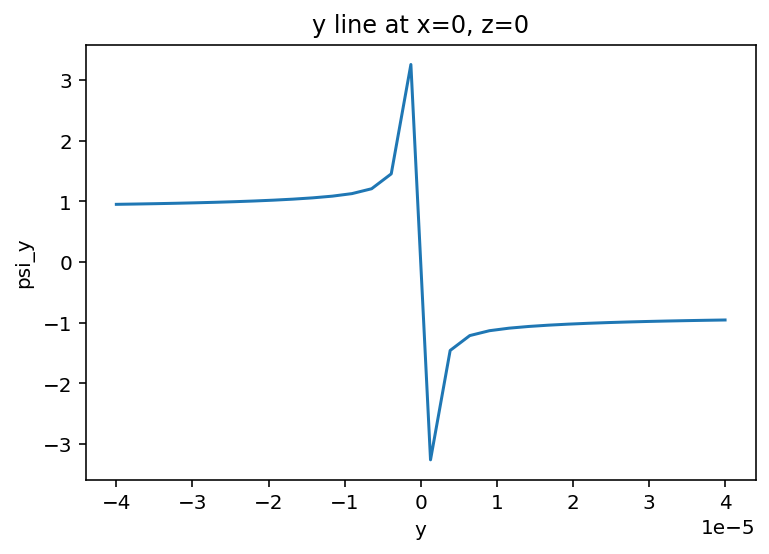

In [48]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_y(0,yvec,0,gamma))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('y')

Text(0.5, 0, 'z')

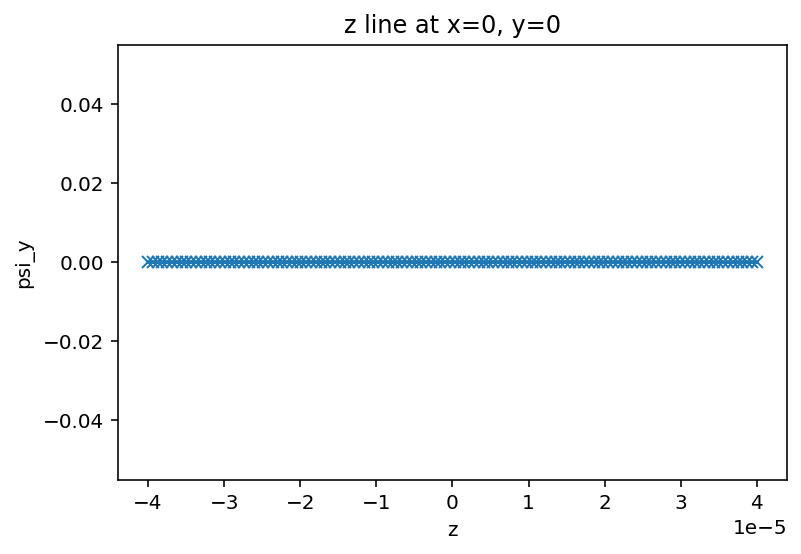

In [49]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_y0(0,0,zvec,gamma,1e-6, 1e-6, 1e-6), marker='x', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('z')